In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from mango.tuner import Tuner

In [11]:
param_space = dict(
    growth=["linear", "logistic", "flat"],
    n_changepoints=range(0, 55, 5),
    changepoint_range=np.linspace(0.5, 1),
    yearly_seasonality=[True, False],
    weekly_seasonality=[True, False],
    daily_seasonality=[True, False],
    seasonality_mode=["additive", "multiplicative"],
    seasonality_prior_scale=np.linspace(5.0, 20.0),
    changepoint_prior_scale=np.linspace(0.0, 0.1),
    interval_width=np.linspace(0.2, 1),
    uncertainty_samples=[500, 1000, 1500, 2000],
)

In [12]:
df = pd.read_csv('CASTHPI.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'observation_date': 'ds', 'CASTHPI': 'y'}, inplace=True)

test size: 40


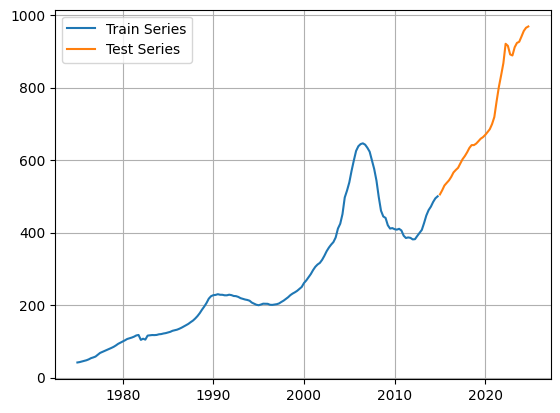

In [13]:
test_size = int(0.2 * len(df))
train_df = df.head(len(df) - test_size)
test_df = df.tail(test_size)
print("test size:", test_size)
plt.plot(train_df['ds'], train_df['y'], label = "Train Series")
plt.plot(test_df['ds'], test_df['y'], label = "Test Series")
plt.legend()
plt.grid()

In [14]:
def objective_function(args_list):
    global train_df, test_df
    params_evaluated = []
    results = []
    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(train_df)
            future = model.make_future_dataframe(periods=test_size, freq="M")
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(test_size)
            error = mean_absolute_percentage_error(
                test_df["y"], predictions_tuned["yhat"]
            )
            params_evaluated.append(params)
            results.append(error)
        except:
            # print(f"Exception raised for {params}")
            # pass
            params_evaluated.append(params)
            results.append(25.0)  # Giving high loss for exceptions regions of spaces

    return params_evaluated, results

In [15]:
tuner = Tuner(param_space, objective_function)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

15:44:18 - cmdstanpy - INFO - Chain [1] start processing


15:44:18 - cmdstanpy - INFO - Chain [1] done processing
15:44:18 - cmdstanpy - INFO - Chain [1] start processing
15:44:18 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.23176554814228761:   5%|▌         | 1/20 [00:17<05:35, 17.67s/it]15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.2134261089003906:  15%|█▌        | 3/20 [00:53<05:00, 17.68s/it] 15:45:30 - cmdstanpy - INFO - Chain [1] start processing
15:45:30 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.2134261089003906:  20%|██        | 4/20 [01:11<04:49, 18.07s/it]15:45:48 - cmdstanpy - INFO - Chain [1] start processing
15:45:48 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.2134261089003906:  35%|███▌      | 7/20 [02:04<03:50, 17.73s/it]15:46:42 - cmdstanpy - INFO - Chain [1] start processing
15:46:42 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.2134261089003906:  45%|████▌     | 9/20 [02:41<03:1

best parameters: {'changepoint_prior_scale': 0.06326530612244899, 'changepoint_range': 0.7653061224489796, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.689795918367347, 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.36734693877551, 'uncertainty_samples': 2000, 'weekly_seasonality': False, 'yearly_seasonality': True}
best loss: 0.21024618876869647


15:57:39 - cmdstanpy - INFO - Chain [1] start processing
15:57:39 - cmdstanpy - INFO - Chain [1] done processing


loss value: 0.16710748949107684


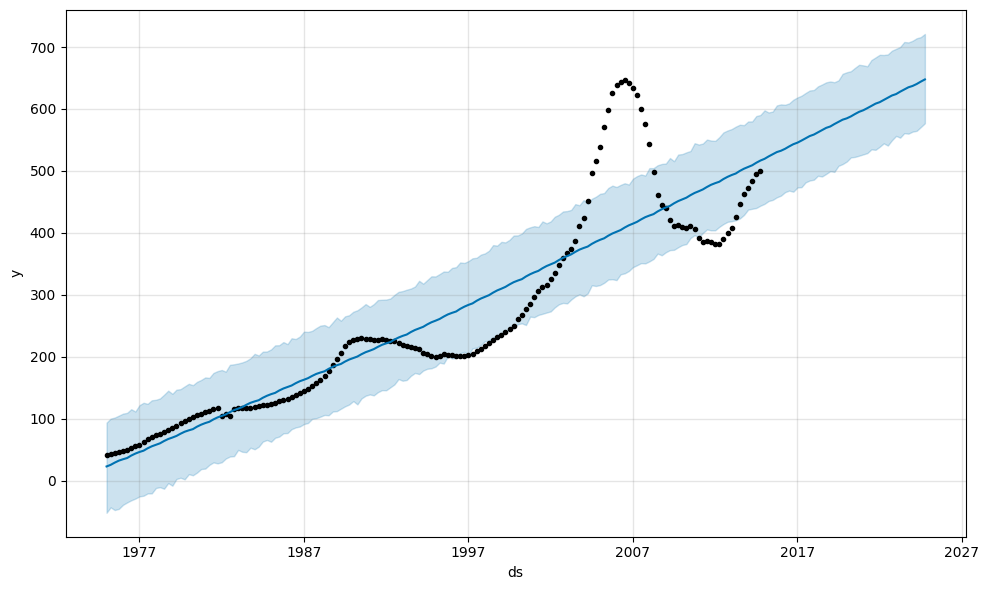

In [17]:
model = Prophet(**results["best_params"])
model.fit(train_df)
future = model.make_future_dataframe(periods=40, freq='Q')
forecast = model.predict(future)
forecast.tail()
error = mean_absolute_percentage_error(test_df['y'], forecast.tail(test_size)['yhat'])   
print('loss value:', error)
model.plot(forecast)
plt.show()